In [20]:
# reload packages
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Choose GPU (this may not be needed on your computer)

In [21]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [22]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### load packages

In [23]:
from tfumap.umap import tfUMAP

In [24]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

In [25]:
from tfumap.umap import tfUMAP

### Load dataset

In [26]:
dataset = 'makosco2015'
dims = (50)

In [27]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

In [28]:
#dataset_address = 'http://file.biolab.si/opentsne/macosko_2015.pkl.gz'
# https://opentsne.readthedocs.io/en/latest/examples/01_simple_usage/01_simple_usage.html
# also see https://github.com/berenslab/rna-seq-tsne/blob/master/umi-datasets.ipynb

In [29]:
import gzip
import pickle

with gzip.open(DATA_DIR / 'macosko_2015.pkl.gz', "rb") as f:
    data = pickle.load(f)

x = data["pca_50"]
y = data["CellType1"].astype(str)

In [30]:
print("Data set contains %d samples with %d features" % x.shape)

Data set contains 44808 samples with 50 features


In [31]:
from sklearn.model_selection import train_test_split

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=.1, random_state=42)

In [33]:
np.shape(X_train)

(40327, 50)

In [34]:
n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

In [35]:
X_train_flat = X_train

In [36]:
X_test_flat = X_test

In [37]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

In [38]:
Y_train = enc.fit_transform([[i] for i in Y_train]).flatten()
Y_test = enc.fit_transform([[i] for i in Y_test]).flatten()

In [39]:
len(X_train), len(X_test), len(X_valid)

(30327, 4481, 10000)

### Create model and train

In [19]:
n_components = 2
encoder = tf.keras.Sequential()
encoder.add(tf.keras.layers.InputLayer(input_shape=dims))
encoder.add(tf.keras.layers.Flatten())
encoder.add(tf.keras.layers.Dense(units=100, activation="relu"))
encoder.add(tf.keras.layers.Dense(units=100, activation="relu"))
encoder.add(tf.keras.layers.Dense(units=100, activation="relu"))
encoder.add(
    tf.keras.layers.Dense(units=n_components, name="z")
)

In [20]:
batch_size = 5000

In [21]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

In [22]:
from tfumap.parametric_tsne import compute_joint_probabilities, tsne_loss

In [23]:
save_loc = DATA_DIR/ 'parametric_tsne'/ dataset / 'P.npy'
if save_loc.exists():
    P = np.load(save_loc)
else:
    P = compute_joint_probabilities(X_train_flat, batch_size=batch_size, perplexity=30, verbose=2)
    ensure_dir(save_loc)
    np.save(save_loc, P)

In [24]:
X_train_subset = X_train[:np.product(P.shape[:2])]

In [25]:
# Joint probabilities of data
Y_train_tsne = P.reshape(X_train_subset.shape[0], -1)

In [26]:
opt = tf.keras.optimizers.Adam(lr=0.01)

In [27]:
encoder.compile(loss=tsne_loss(d=n_components, batch_size=batch_size), optimizer=opt)

In [28]:
X_train_subset = np.reshape(X_train_subset, ([len(X_train_subset)]+ [dims]))
X_test = np.reshape(X_test, ([len(X_test)]+ [dims]))

In [29]:
# because shuffle == False, the same batches are used each time...
history = encoder.fit(X_train_subset, Y_train_tsne, batch_size=batch_size, shuffle=False, nb_epoch=1000)

W0720 10:51:57.302856 139919644428096 training.py:792] The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 30000 samples
Epoch 1/1000
30000/30000 [==============================] - 7s 227us/sample - loss: 3.3040
Epoch 2/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 2.4975
Epoch 3/1000
30000/30000 [==============================] - 0s 12us/sample - loss: 2.3779
Epoch 4/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 2.2909
Epoch 5/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 2.2322
Epoch 6/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 2.1934
Epoch 7/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 2.1647
Epoch 8/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 2.1397
Epoch 9/1000
30000/30000 [==============================] - 0s 12us/sample - loss: 2.1175
Epoch 10/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 2.0970
Epoch 11/1000
30000/30000 [==============================] - 0s 11us/sample

30000/30000 [==============================] - 0s 12us/sample - loss: 1.8421
Epoch 91/1000
30000/30000 [==============================] - 1s 20us/sample - loss: 1.8388
Epoch 92/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.8393
Epoch 93/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.8403
Epoch 94/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.8416
Epoch 95/1000
30000/30000 [==============================] - 0s 14us/sample - loss: 1.8430
Epoch 96/1000
30000/30000 [==============================] - 1s 19us/sample - loss: 1.8402
Epoch 97/1000
30000/30000 [==============================] - 0s 12us/sample - loss: 1.8368
Epoch 98/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.8372
Epoch 99/1000
30000/30000 [==============================] - 0s 12us/sample - loss: 1.8361
Epoch 100/1000
30000/30000 [==============================] - 1s 22us/sample - loss: 1.8354
Epoch 101/10

30000/30000 [==============================] - 0s 11us/sample - loss: 1.8022
Epoch 180/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.8043
Epoch 181/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.8008
Epoch 182/1000
30000/30000 [==============================] - 1s 19us/sample - loss: 1.8018
Epoch 183/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.7972
Epoch 184/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.7958
Epoch 185/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.7939
Epoch 186/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.7949
Epoch 187/1000
30000/30000 [==============================] - 0s 16us/sample - loss: 1.7968
Epoch 188/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.7942
Epoch 189/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.7930
Epo

30000/30000 [==============================] - 0s 11us/sample - loss: 1.7800
Epoch 269/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.7806
Epoch 270/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.7800
Epoch 271/1000
30000/30000 [==============================] - 0s 12us/sample - loss: 1.7809
Epoch 272/1000
30000/30000 [==============================] - 0s 12us/sample - loss: 1.7800
Epoch 273/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.7801
Epoch 274/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.7798
Epoch 275/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.7811
Epoch 276/1000
30000/30000 [==============================] - 0s 12us/sample - loss: 1.7813
Epoch 277/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.7812
Epoch 278/1000
30000/30000 [==============================] - 0s 12us/sample - loss: 1.7841
Epo

30000/30000 [==============================] - 0s 12us/sample - loss: 1.7717
Epoch 358/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.7727
Epoch 359/1000
30000/30000 [==============================] - 0s 12us/sample - loss: 1.7705
Epoch 360/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.7698
Epoch 361/1000
30000/30000 [==============================] - 0s 12us/sample - loss: 1.7708
Epoch 362/1000
30000/30000 [==============================] - 0s 12us/sample - loss: 1.7708
Epoch 363/1000
30000/30000 [==============================] - 1s 19us/sample - loss: 1.7712
Epoch 364/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.7699
Epoch 365/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.7687
Epoch 366/1000
30000/30000 [==============================] - 0s 12us/sample - loss: 1.7693
Epoch 367/1000
30000/30000 [==============================] - 0s 14us/sample - loss: 1.7701
Epo

30000/30000 [==============================] - 0s 11us/sample - loss: 1.7603
Epoch 447/1000
30000/30000 [==============================] - 0s 12us/sample - loss: 1.7605
Epoch 448/1000
30000/30000 [==============================] - 0s 12us/sample - loss: 1.7625
Epoch 449/1000
30000/30000 [==============================] - 0s 14us/sample - loss: 1.7622
Epoch 450/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.7610
Epoch 451/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.7604
Epoch 452/1000
30000/30000 [==============================] - 0s 12us/sample - loss: 1.7589
Epoch 453/1000
30000/30000 [==============================] - 0s 12us/sample - loss: 1.7589
Epoch 454/1000
30000/30000 [==============================] - 0s 13us/sample - loss: 1.7583
Epoch 455/1000
30000/30000 [==============================] - 1s 17us/sample - loss: 1.7580
Epoch 456/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.7591
Epo

30000/30000 [==============================] - 0s 10us/sample - loss: 1.7563
Epoch 536/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.7543
Epoch 537/1000
30000/30000 [==============================] - 0s 14us/sample - loss: 1.7546
Epoch 538/1000
30000/30000 [==============================] - 0s 12us/sample - loss: 1.7552
Epoch 539/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.7552
Epoch 540/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.7570
Epoch 541/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.7549
Epoch 542/1000
30000/30000 [==============================] - 0s 12us/sample - loss: 1.7569
Epoch 543/1000
30000/30000 [==============================] - 0s 15us/sample - loss: 1.7561
Epoch 544/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.7551
Epoch 545/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.7548
Epo

30000/30000 [==============================] - 0s 11us/sample - loss: 1.7540
Epoch 625/1000
30000/30000 [==============================] - 0s 14us/sample - loss: 1.7526
Epoch 626/1000
30000/30000 [==============================] - 0s 12us/sample - loss: 1.7540
Epoch 627/1000
30000/30000 [==============================] - 0s 13us/sample - loss: 1.7530
Epoch 628/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.7512
Epoch 629/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.7513
Epoch 630/1000
30000/30000 [==============================] - 0s 13us/sample - loss: 1.7520
Epoch 631/1000
30000/30000 [==============================] - 0s 14us/sample - loss: 1.7532
Epoch 632/1000
30000/30000 [==============================] - 0s 12us/sample - loss: 1.7518
Epoch 633/1000
30000/30000 [==============================] - 0s 11us/sample - loss: 1.7525
Epoch 634/1000
30000/30000 [==============================] - 0s 12us/sample - loss: 1.7527
Epo

30000/30000 [==============================] - 1s 18us/sample - loss: 1.7462
Epoch 714/1000
30000/30000 [==============================] - 0s 16us/sample - loss: 1.7469
Epoch 715/1000
30000/30000 [==============================] - 0s 15us/sample - loss: 1.7468
Epoch 716/1000
30000/30000 [==============================] - 0s 15us/sample - loss: 1.7447
Epoch 717/1000
30000/30000 [==============================] - 1s 19us/sample - loss: 1.7449
Epoch 718/1000
30000/30000 [==============================] - 1s 20us/sample - loss: 1.7448
Epoch 719/1000
30000/30000 [==============================] - 0s 15us/sample - loss: 1.7424
Epoch 720/1000
30000/30000 [==============================] - 0s 16us/sample - loss: 1.7432
Epoch 721/1000
30000/30000 [==============================] - 0s 15us/sample - loss: 1.7448
Epoch 722/1000
30000/30000 [==============================] - 1s 22us/sample - loss: 1.7451
Epoch 723/1000
30000/30000 [==============================] - 0s 15us/sample - loss: 1.7446
Epo

30000/30000 [==============================] - 0s 14us/sample - loss: 1.7452
Epoch 803/1000
30000/30000 [==============================] - 1s 20us/sample - loss: 1.7431
Epoch 804/1000
30000/30000 [==============================] - 0s 14us/sample - loss: 1.7446
Epoch 805/1000
30000/30000 [==============================] - 0s 13us/sample - loss: 1.7432
Epoch 806/1000
30000/30000 [==============================] - 0s 13us/sample - loss: 1.7432
Epoch 807/1000
30000/30000 [==============================] - 0s 13us/sample - loss: 1.7432
Epoch 808/1000
30000/30000 [==============================] - 1s 20us/sample - loss: 1.7419
Epoch 809/1000
30000/30000 [==============================] - 0s 14us/sample - loss: 1.7426
Epoch 810/1000
30000/30000 [==============================] - 0s 16us/sample - loss: 1.7413
Epoch 811/1000
30000/30000 [==============================] - 0s 14us/sample - loss: 1.7390
Epoch 812/1000
30000/30000 [==============================] - 1s 18us/sample - loss: 1.7411
Epo

30000/30000 [==============================] - 0s 15us/sample - loss: 1.7394
Epoch 892/1000
30000/30000 [==============================] - 0s 17us/sample - loss: 1.7375
Epoch 893/1000
30000/30000 [==============================] - 1s 17us/sample - loss: 1.7381
Epoch 894/1000
30000/30000 [==============================] - 0s 14us/sample - loss: 1.7375
Epoch 895/1000
30000/30000 [==============================] - 0s 13us/sample - loss: 1.7381
Epoch 896/1000
30000/30000 [==============================] - 0s 14us/sample - loss: 1.7372
Epoch 897/1000
30000/30000 [==============================] - 0s 13us/sample - loss: 1.7361
Epoch 898/1000
30000/30000 [==============================] - 0s 13us/sample - loss: 1.7352
Epoch 899/1000
30000/30000 [==============================] - 0s 12us/sample - loss: 1.7354
Epoch 900/1000
30000/30000 [==============================] - 0s 12us/sample - loss: 1.7342
Epoch 901/1000
30000/30000 [==============================] - 0s 14us/sample - loss: 1.7356
Epo

30000/30000 [==============================] - 0s 14us/sample - loss: 1.7360
Epoch 981/1000
30000/30000 [==============================] - 1s 19us/sample - loss: 1.7348
Epoch 982/1000
30000/30000 [==============================] - 0s 16us/sample - loss: 1.7351
Epoch 983/1000
30000/30000 [==============================] - 0s 14us/sample - loss: 1.7370
Epoch 984/1000
30000/30000 [==============================] - 0s 14us/sample - loss: 1.7380
Epoch 985/1000
30000/30000 [==============================] - 0s 13us/sample - loss: 1.7387
Epoch 986/1000
30000/30000 [==============================] - 1s 21us/sample - loss: 1.7372
Epoch 987/1000
30000/30000 [==============================] - 0s 15us/sample - loss: 1.7391
Epoch 988/1000
30000/30000 [==============================] - 0s 13us/sample - loss: 1.7393
Epoch 989/1000
30000/30000 [==============================] - 0s 14us/sample - loss: 1.7396
Epoch 990/1000
30000/30000 [==============================] - 0s 16us/sample - loss: 1.7384
Epo

### get z for training and test

In [34]:
z = encoder.predict(X_train)
z_test = encoder.predict(X_test)

### Test plot

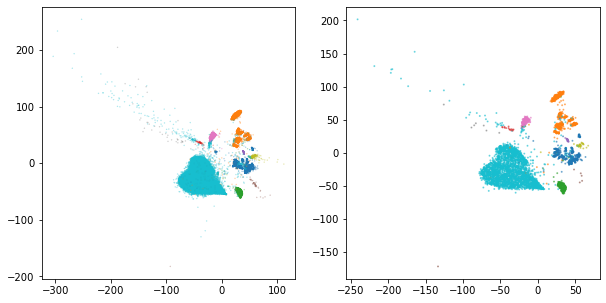

In [33]:
fig, axs = plt.subplots(ncols = 2, figsize=(10, 5))
axs[0].scatter(z[:, 0], z[:, 1], s=0.1, alpha=0.5, c=Y_train, cmap=plt.cm.tab10)
axs[1].scatter(z_test[:, 0], z_test[:, 1], s=1, alpha=0.5, c=Y_test, cmap=plt.cm.tab10)

### Save models + projections

In [35]:
import os

In [36]:
output_dir = MODEL_DIR/'projections'/ dataset / 'parametric-tsne'

In [37]:
encoder.save(os.path.join(output_dir, "encoder"))

W0720 10:59:32.332256 139919644428096 deprecation.py:506] From /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
I0720 10:59:32.473590 139919644428096 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/macosko2015/parametric-tsne/encoder/assets


In [38]:
np.save(output_dir / 'z.npy', z)
np.save(output_dir / 'z_test.npy', z_test)

### compute metrics

#### silhouette

In [39]:
from tfumap.silhouette import silhouette_score_block

In [40]:
ss, sil_samp = silhouette_score_block(z, Y_train, n_jobs = -1)
ss

0.25781010509610297

In [41]:
ss_test, sil_samp_test = silhouette_score_block(z_test, Y_test, n_jobs = -1)
ss_test

0.27818000236246804

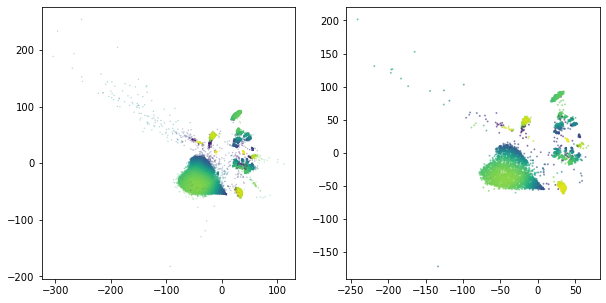

In [42]:
fig, axs = plt.subplots(ncols = 2, figsize=(10, 5))
axs[0].scatter(z[:, 0], z[:, 1], s=0.1, alpha=0.5, c=sil_samp, cmap=plt.cm.viridis)
axs[1].scatter(z_test[:, 0], z_test[:, 1], s=1, alpha=0.5, c=sil_samp_test, cmap=plt.cm.viridis)

#### KNN

In [43]:
from sklearn.neighbors import KNeighborsClassifier

In [44]:
neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(z, Y_train)
score_5nn = neigh5.score(z_test, Y_test)
score_5nn

0.9765677304173176

In [45]:
neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(z, Y_train)
score_1nn = neigh1.score(z_test, Y_test)
score_1nn

0.9660790002231645

#### Trustworthiness

In [46]:
from sklearn.manifold import trustworthiness

In [47]:
tw = trustworthiness(X_train_flat[:10000], z[:10000])

In [50]:
tw_test = trustworthiness(X_test_flat[:10000], z_test[:10000])

In [51]:
tw, tw_test

(0.94628346877502, 0.9323337580592783)

#### save output metrics

In [52]:
metrics_df = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df.loc[len(metrics_df)] = [dataset, 'parametric-tsne', n_components, tw, ss, sil_samp]
metrics_df

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
0,macosko2015,parametric-tsne,2,0.946283,0.25781,"[0.3406608482046336, 0.8008643850128306, 0.103..."


In [53]:
save_loc = DATA_DIR / 'projection_metrics' / 'train' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

In [54]:
metrics_df_test = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df_test.loc[len(metrics_df)] = [dataset, 'parametric-tsne', n_components, tw_test, ss_test, sil_samp_test]
metrics_df_test

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
1,macosko2015,parametric-tsne,2,0.932334,0.27818,"[0.5069764644083584, 0.16612674525714405, 0.53..."


In [55]:
save_loc = DATA_DIR / 'projection_metrics' / 'test' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

In [56]:
nn_acc_df = pd.DataFrame(columns = ["method_","dimensions","dataset","1NN_acc","5NN_acc"])
nn_acc_df.loc[len(nn_acc_df)] = ['parametric-tsne', n_components, dataset,  score_1nn, score_5nn]
nn_acc_df

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,parametric-tsne,2,macosko2015,0.966079,0.976568


In [57]:
save_loc = DATA_DIR / 'knn_classifier' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
nn_acc_df.to_pickle(save_loc)